In [15]:
#dataframe
import pandas as pd

#plots
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn import preprocessing

#model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


#model assessment
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#dealing with class imbalance
from imblearn.under_sampling import RandomUnderSampler
#, RandomOverSampler

#tuning
from sklearn.model_selection import GridSearchCV

In [16]:
#pip install -U imbalanced-learn

In [17]:
waze_cleaned = pd.read_csv("../data/waze_processed.csv")
waze_cleaned.head(3)

,Android,iPhone,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,1,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19
1,0,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11
2,1,0,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8


<h3> Classes are inherently imbalanced

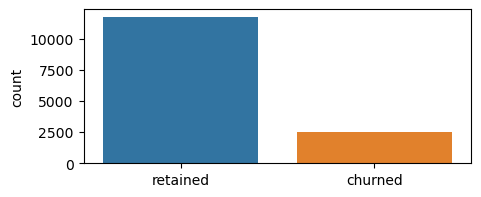

In [18]:
plt.figure(figsize = (5,2))
sns.countplot(x = waze_cleaned["label"])
plt.xlabel("");

In [19]:
retained_count = waze_cleaned['label'].value_counts().get("retained", 0)
churn_count = waze_cleaned['label'].value_counts().get("churned", 0)
churn_rate = churn_count/(churn_count+retained_count)
print("Total retained count:", retained_count)
print("Total churn count:", churn_count)
print("Churn rate", round(churn_rate, 2))

Total retained count: 11763
Total churn count: 2536
Churn rate 0.18


In [20]:
#The above cells show that the data is unbalanced. 
#Resample to balance classes. 

In [21]:
#convert values in label column to 1 (churned) or 0 (retained)
waze_cleaned['label']= waze_cleaned['label'].apply(lambda x: True if x == 'churned' else False).astype(int)
waze_cleaned.head(3)

,Android,iPhone,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,1,0,0,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19
1,0,1,0,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11
2,1,0,0,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8


<h3> Split data into testing and training datasets and standardize

In [22]:
#Split data into testing and training datasets
X = waze_cleaned.drop('label', axis = 1)
y = waze_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Standardize the magnitude of numeric features using a scaler
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)


In [23]:
#Change balance of imbalanced classes in dependent variable
sampling_strategy = 1
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_train_scaled_res, y_res = rus.fit_resample(X_train_scaled, y_train)

In [24]:
y_res.value_counts()

label
0    2013
1    2013
Name: count, dtype: int64

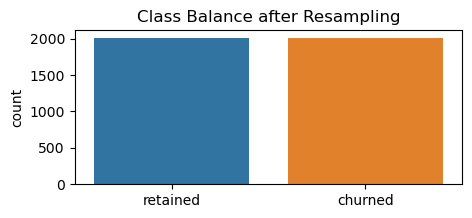

In [25]:
# Convert y_res to a DataFrame for visualization
y_res_df = pd.DataFrame(y_res, columns=['label'])

# Visualize the new class balance
plt.figure(figsize = (5, 2))
sns.countplot(x = y_res_df["label"])
plt.xlabel("")
plt.xticks([0, 1], ['retained', 'churned'])
plt.title("Class Balance after Resampling")
plt.show()

In [26]:
retained_count = y_res_df["label"].value_counts().get(0, 0)
churn_count = y_res_df["label"].value_counts().get(1, 0)
churn_rate = churn_count/(churn_count+retained_count)
print("Total retained count:", retained_count)
print("Total churn count:", churn_count)
print("Churn rate", round(churn_rate, 2))

Total retained count: 2013
Total churn count: 2013
Churn rate 0.5


In [27]:
#rename variables to those used before resampling
X_train_scaled = X_train_scaled_res
y_train = y_res

<h1> Logistic Regression

In [28]:
#Instantiate the model and set parameters
#I also tried the newton_cg solver, but went with liblinear and l2 (default) (Ridge) regularization. Similar accuracy results
clf_lr = LogisticRegression(solver = 'liblinear', max_iter = 500, random_state = 45)
#Fit the model using training set
clf_lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500, random_state=45, solver='liblinear')

In [29]:
#Predict y test and check accuracy on predicting test set
y_predict = clf_lr.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf_lr.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.672027972027972
train accuracy: 0.6922503725782414


While checking for accuracy is only the first step, the well matched train/test accuracy (low variance, with only slightly higher accuracy for training set) is a good start with no obvious over/underfitting. I tried a confusion matrix and got array([[  34,  463],
       [  39, 2324]]), then different results, so went back and set a random state of 45 for consistent results

In [30]:
cm = confusion_matrix(y_test, y_predict, labels = clf_lr.classes_)
cm

array([[1555,  782],
       [ 156,  367]])

In [31]:
# Define the grid of values for C
param_grid = {'C': np.logspace(-4, 4, 20)}

# Implement Grid Search
grid_search = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print the best C value
best_C = grid_search.best_params_['C']
print(f"The best C value using accuracy scoring is: {best_C}")

The best C value using accuracy scoring is: 0.004832930238571752


In [32]:
#reattempt using recall as scoring method
grid_search = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

# Print the best C value
best_C = grid_search.best_params_['C']
print(f"The best C value using recall scoring is: {best_C}")


The best C value using recall scoring is: 0.0001


In [33]:
#Instantiate the model and set parameters
#I also tried the newton_cg solver, but went with liblinear and l2 (default) (Ridge) regularization. Similar accuracy results
clf_lr = LogisticRegression(C = .0001, solver = 'liblinear', max_iter = 500, random_state = 45)
#Fit the model using training set
clf_lr.fit(X_train_scaled, y_train)

LogisticRegression(C=0.0001, max_iter=500, random_state=45, solver='liblinear')

In [34]:
#Predict y test and check accuracy on predicting test set
y_predict = clf_lr.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf_lr.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.6111888111888112
train accuracy: 0.6870342771982116


In [35]:
#Predict y test and check accuracy on predicting test set
y_predict = clf_lr.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf_lr.predict(X_train_scaled)
train_recall = recall_score(y_train, y_train_predicted)

print("test recall:", test_recall)
print("train recall:", train_recall)

test recall: 0.7782026768642447
train recall: 0.7978142076502732


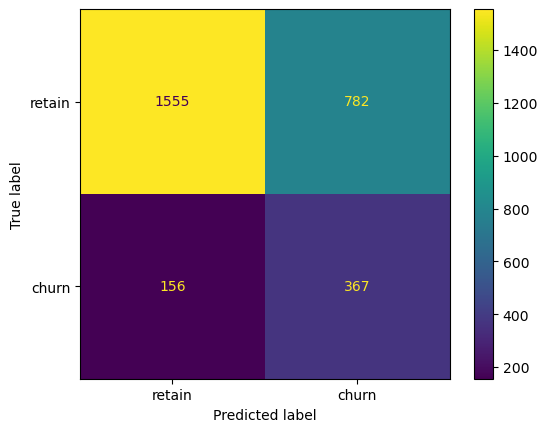

In [36]:
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = ['retain', 'churn'])
display_cm.plot(ax = ax);

In [37]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.92      0.57      0.71      2337
           1       0.29      0.78      0.42       523

    accuracy                           0.61      2860
   macro avg       0.61      0.68      0.56      2860
weighted avg       0.81      0.61      0.65      2860



<h1> K Nearest Neighbors 

In [38]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train_scaled,y_train)

y_pred = knn.predict(X_test_scaled)

In [39]:
#Predict y test and check accuracy on predicting test set
y_predict = knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = knn.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.7094405594405594
train accuracy: 0.7555886736214605


In [40]:
#Use GridSearchCV to confirm best K value. Try a wider range
param_grid = {'n_neighbors': range(1, 20)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)

best_k = grid_search.best_params_['n_neighbors']
print('Best K value:', best_k) 
print('Best Accuracy:', best_accuracy)

Best K value: 18
Best Accuracy: 0.6758741258741259


In [41]:
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train_scaled,y_train)

y_pred = knn.predict(X_test_scaled)

In [42]:
#Predict y test and check accuracy on predicting test set
y_predict = knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = knn.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.6758741258741259
train accuracy: 0.7016890213611525


In [43]:
#Predict y test and check recall on predicting test set
y_predict = knn.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)

#check recall of model on training set to check for over/underfitting
y_train_predicted = knn.predict(X_train_scaled)
train_recall = recall_score(y_train, y_train_predicted)

print("test recall:", test_recall)
print("train recall:", train_recall)

test recall: 0.6347992351816444
train recall: 0.6939890710382514


In [44]:
report = classification_report(y_test, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.69      0.78      2337
           1       0.31      0.63      0.42       523

    accuracy                           0.68      2860
   macro avg       0.60      0.66      0.60      2860
weighted avg       0.79      0.68      0.71      2860



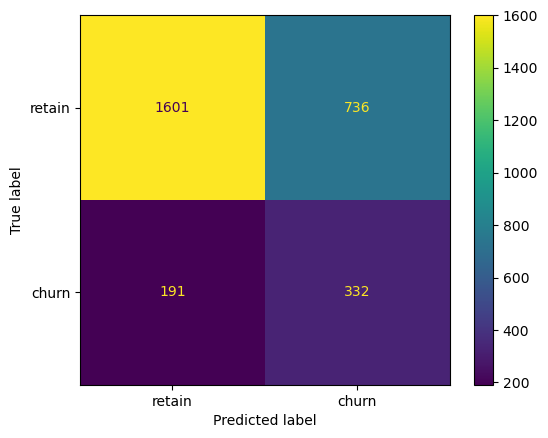

In [45]:
cm = confusion_matrix(y_test, y_predict, labels = knn.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = ['retain', 'churn'])
display_cm.plot(ax = ax);

<h2> Random Forest

In [46]:
clf_rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)
model_res = clf_rf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print('Random Forest Accuracy = ', ac)
print('Random Forest f1-score =' , f1)

Random Forest Accuracy =  0.6674825174825175
Random Forest f1-score = 0.7041202463892817


In [47]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1545,  792],
       [ 159,  364]])

In [48]:
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = ['retain', 'churn'])
display_cm.plot(ax = ax);

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.66      0.76      2337
           1       0.31      0.70      0.43       523

    accuracy                           0.67      2860
   macro avg       0.61      0.68      0.60      2860
weighted avg       0.80      0.67      0.70      2860



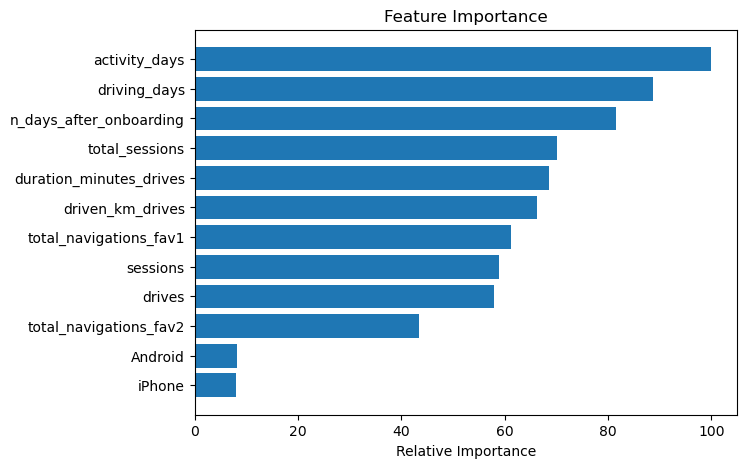

In [50]:
feature_importance = clf_rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show();

<h2> Gradient Boost with XGBoost

In [51]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
model_res = clf_xgb.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm

              precision    recall  f1-score   support

           0       0.90      0.63      0.74      2337
           1       0.29      0.67      0.41       523

    accuracy                           0.64      2860
   macro avg       0.59      0.65      0.57      2860
weighted avg       0.79      0.64      0.68      2860



array([[1472,  865],
       [ 170,  353]])

In [52]:
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = ['retain', 'churn'])
display_cm.plot(ax = ax);

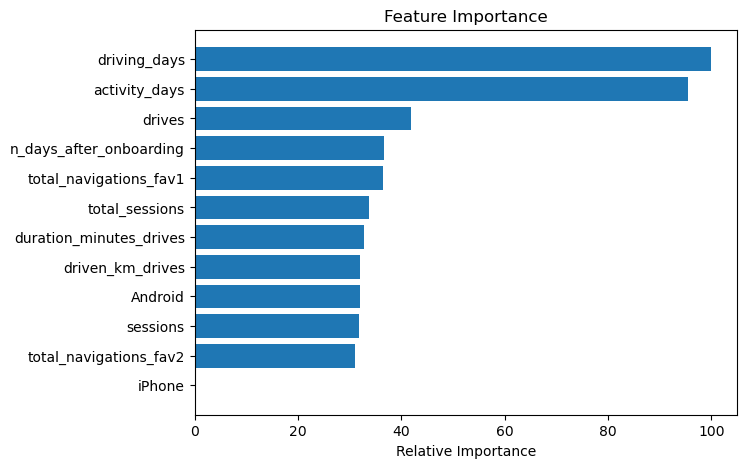

In [54]:
feature_importance = clf_xgb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show();

Conclusion: Even without optimization, the gradient boost model gives the best results. As our primary business interest is to identify churn, we prioritize sensitivity (recall), the true positive rate. 

The random forest model had very slightly higher scores for precision and the related score f1. It might be worthwhile to discuss how the model results will be used with stakeholders. If the planned intervention on customers at risk of churn is expensive or limited, elevating the importance of precision may be warranted. 